In [1]:
import simon_64_128
import logger
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng()

In [24]:
NUM_MEASUREMENTS = 1000
VALS_PER_MEASUREMENT = 45


In [ ]:
CORR_DIFF_THRESHOLD = 0.05
"""If a key guess with maximum positive correlation and a key guess with negative correlation have a similar absolute value,
both guesses are taken as hypothesis. If the sum of the highest and lowest correlation is between `-CORR_DIFF_POS_NEG` and `CORR_DIFF_POS_NEG`,
both guesses will be accepted. Otherwise, only the guess with the higher absolute correlation is taken. 
"""

def filter_key_guesses(key_guess_pos: np.uint8, corr_pos: np.float64, key_guess_neg: np.uint8, corr_neg: np.float64) -> list[np.uint8]:
    res = []
    if (corr_pos + corr_neg) < -CORR_DIFF_THRESHOLD:
        # negative correlation is stronger.
        return [key_guess_neg]
    if (corr_pos + corr_neg) > CORR_DIFF_THRESHOLD:
        # positive correlation is stronger.
        return [key_guess_pos]
    else:
        # both correlations are in a similar range
        return [key_guess_pos, key_guess_neg]



In [3]:
def get_x_values_from_log(log: logger.Log) -> np.ndarray:
    x_values = []
    for e in log.entries:
        if e.label.startswith("X"):
            x_values.append(e.content)
    return np.array(x_values, dtype=np.uint32)

def log_to_measurement(log: logger.Log) -> np.ndarray:
    x_values = get_x_values_from_log(log)
    return np.bitwise_count(x_values)

In [4]:
def get_x_for_guessed_key(plaintext: np.ndarray, guessed_key: np.ndarray, round: int) -> np.integer:
    x_values = simon_64_128.encrypt_block_light(plaintext, guessed_key)
    return x_values[round]

def get_hw_for_guessed_key_byte(plaintext: np.ndarray, guessed_key: np.ndarray, round: int, mask: int) -> int:
    x_i = get_x_for_guessed_key(plaintext, guessed_key, round)
    return (x_i & mask).bit_count()

In [20]:
def find_best_correlation(expected_hws: np.ndarray, consumptions: np.ndarray) -> np.float64:
    """ Go through all timepoints and find the one with the maximum correlation to hamming weights (positive or negative).
    Example: 
        - 1000 measurements, each with 45 timepoints
        - expected_hws: [8, ..., 1] # Shape = 1000
        - consumptions: [[27, ...,  17], 
                         [30, ...,   2], 
                         ... 
                         [11, ...,  11]] # Shape = (1000, 45)
                           |    |    |
                          0.5  ...  0.1  <- Correlations for each timepoint
        - returns 0.5

    """
    assert expected_hws.shape[0] == consumptions.shape[0]
    
    correlations = np.array([np.corrcoef(expected_hws, consumptions[:, t])[0, 1] for t in range(consumptions.shape[1])], dtype=np.float64)
    if np.max(correlations) > -np.min(correlations):
        return np.max(correlations)
    else:
        return np.min(correlations)

In [19]:
def array_to_hex_str(val: np.ndarray) -> str:
    if val.dtype == np.uint8:
        return " ".join(f"0x{e:02X}" for e in val)
    else:
        return " ".join(f"0x{e:08X}" for e in val)


In [7]:
key = rng.integers(0, 2**32, 4, dtype=np.uint32)

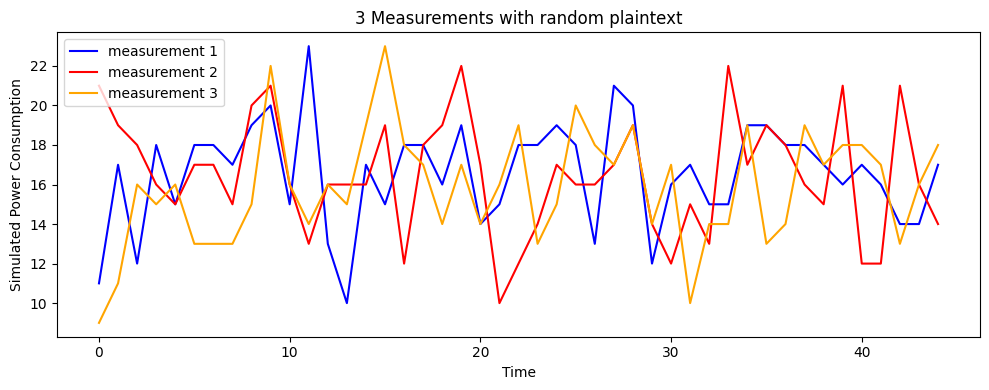

In [8]:
 # Perform 1000 simulated measurements
measurements = []

for i in range(NUM_MEASUREMENTS):
    plaintext = rng.integers(0, 2**32, 2, dtype=np.uint32)
    ciphertext, log = simon_64_128.encrypt_block(plaintext, key)
    current_consumption = log_to_measurement(log)

    measurements.append((plaintext, ciphertext, current_consumption))

# Draw 3 simulated traces
plt.figure(figsize=(10,4))
vals1 = measurements[0][2]
vals2 = measurements[1][2]
vals3 = measurements[2][2]


plt.plot(vals1, color='blue', label='measurement 1')
plt.plot(vals2, color='red', label='measurement 2')
plt.plot(vals3, color='orange', label='measurement 3')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Simulated Power Consumption")
plt.title("3 Measurements with random plaintext")
plt.tight_layout()
plt.show()


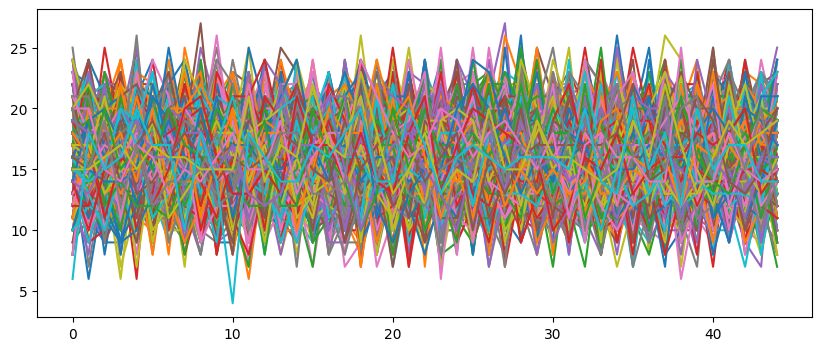

In [9]:
# Draw all simulated traces
plt.figure(figsize=(10,4))

# Go through all measurements and get current consumption as 2D-array
consumptions = np.array([m[2] for m in measurements], dtype=np.uint32)

x = np.arange(consumptions.shape[1])
for trace in consumptions:
    plt.plot(x, trace)


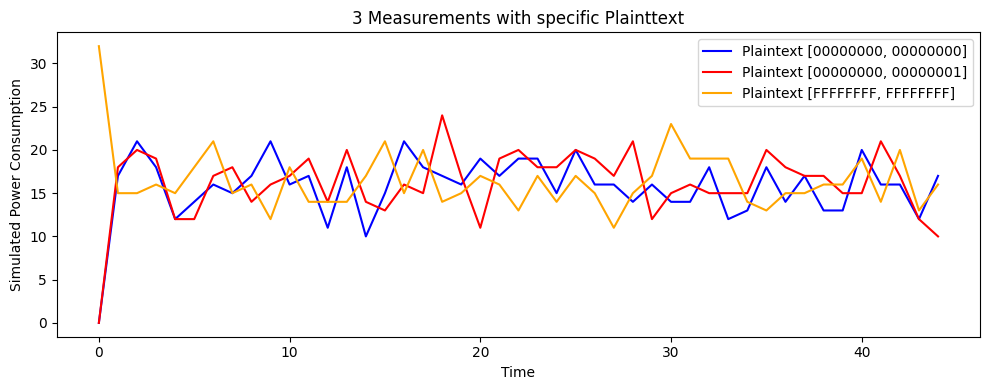

In [10]:
plaintext1 = np.array([0,0], dtype=np.uint32)
_, log1 = simon_64_128.encrypt_block(plaintext1, key)

plaintext2 = np.array([0,1], dtype=np.uint32)
_, log2 = simon_64_128.encrypt_block(plaintext2, key)

plaintext3 = np.array([0xFFFFFFFF,0xFFFFFFFF], dtype=np.uint32)
_, log3 = simon_64_128.encrypt_block(plaintext3, key)

current_consumption1 = log_to_measurement(log1)
current_consumption2 = log_to_measurement(log2)
current_consumption3 = log_to_measurement(log3)

plt.figure(figsize=(10,4))
vals1 = current_consumption1
vals2 = current_consumption2
vals3 = current_consumption3

plt.plot(vals1, color='blue', label='Plaintext [00000000, 00000000]')
plt.plot(vals2, color='red', label='Plaintext [00000000, 00000001]')
plt.plot(vals3, color='orange', label='Plaintext [FFFFFFFF, FFFFFFFF]')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Simulated Power Consumption")
plt.title("3 Measurements with specific Plainttext")
plt.tight_layout()
plt.show()

In [11]:
ATTACK_TABLE = [
    # Key word, Cipher Round to Attack, Byte Shift within key word
    (3, 0, 0),
    (3, 0, 8),
    (3, 0, 16),
    (3, 0, 24),
    (2, 1, 0),
    (2, 1, 8),
    (2, 1, 16),
    (2, 1, 24),
    (1, 2, 0),
    (1, 2, 8),
    (1, 2, 16),
    (1, 2, 24),
    (0, 3, 0),
    (0, 3, 8),
    (0, 3, 16),
    (0, 3, 24),
]


In [21]:
# Go through all measurements and get current consumption as 2D-array
consumptions = np.array([m[2] for m in measurements], dtype=np.uint32)

# start with empty key
current_key = np.zeros((4,), dtype=np.uint32)

for attack_idx, attack_spec in enumerate(ATTACK_TABLE):
    print(f"Perform Attack Step {attack_idx+1}/{len(ATTACK_TABLE)}")
    key_word_idx = attack_spec[0]
    round_to_attack = attack_spec[1]
    byte_shift = attack_spec[2]
    byte_mask = 0xFF << byte_shift

    # Prepare a table with correlations for each possible byte value
    key_corrs = np.zeros((256,), dtype=np.float32)

    for guessed_byte in range(256):
        guessed_key = current_key.copy()
        guessed_key[key_word_idx] |= guessed_byte << byte_shift

        # Go through all measurements and get expected hamming weights for guessed byte as 1D-array
        predicted_hws = np.array(
                [get_hw_for_guessed_key_byte(m[0], guessed_key, round_to_attack, byte_mask) for m in measurements], 
                dtype=np.uint32)

        # Find max correlation for current guessed byte
        max_corr_one_guess = find_best_correlation(predicted_hws, consumptions)
        key_corrs[guessed_byte] = max_corr_one_guess

    max_corr_pos = np.max(key_corrs)
    max_corr_neg = np.min(key_corrs)
    best_byte_guess_pos = np.argmax(key_corrs)
    best_byte_guess_neg = np.argmax(key_corrs)
    print(f"Best guesses for key byte {attack_idx}: 0x{best_byte_guess_pos:02X} (corr: {max_corr_pos}) and 0x{best_byte_guess_neg:02X} (corr: {max_corr_neg}). Second best correlation: {np.partition(key_corrs.flatten(), -2)[-2]}")
    current_key[key_word_idx] |= best_byte_guess_pos << byte_shift
    print(f"Current key: {array_to_hex_str(current_key)}")

print(f"Best guess for complete key: {array_to_hex_str(current_key)}")


Perform Attack Step 1/16
Best guesses for key byte 0: 0x32 (corr: 0.5088030099868774) and 0x32 (corr: -0.5088030099868774). Second best correlation: 0.4048430621623993
Current key: 0x00000000 0x00000000 0x00000000 0x00000032
Perform Attack Step 2/16
Best guesses for key byte 1: 0xFE (corr: 0.48623740673065186) and 0xFE (corr: -0.48623740673065186). Second best correlation: 0.3957687020301819
Current key: 0x00000000 0x00000000 0x00000000 0x0000FE32
Perform Attack Step 3/16
Best guesses for key byte 2: 0x15 (corr: 0.4942421317100525) and 0x15 (corr: -0.4942421317100525). Second best correlation: 0.41702911257743835
Current key: 0x00000000 0x00000000 0x00000000 0x0015FE32
Perform Attack Step 4/16
Best guesses for key byte 3: 0xCC (corr: 0.4873882234096527) and 0xCC (corr: -0.4873882234096527). Second best correlation: 0.3808385729789734
Current key: 0x00000000 0x00000000 0x00000000 0xCC15FE32
Perform Attack Step 5/16
Best guesses for key byte 4: 0xE8 (corr: 0.4949854910373688) and 0xE8 (c

In [13]:
print(f"Actual key: {array_to_hex_str(key)}")
print(f"Differences: {array_to_hex_str(current_key ^ key)}")

Actual key: 0xEF1619C3 0x7DD39CDE 0xB2C033E8 0xCC15FE32
Differences: 0x00000000 0x00000000 0x00000000 0x00000000


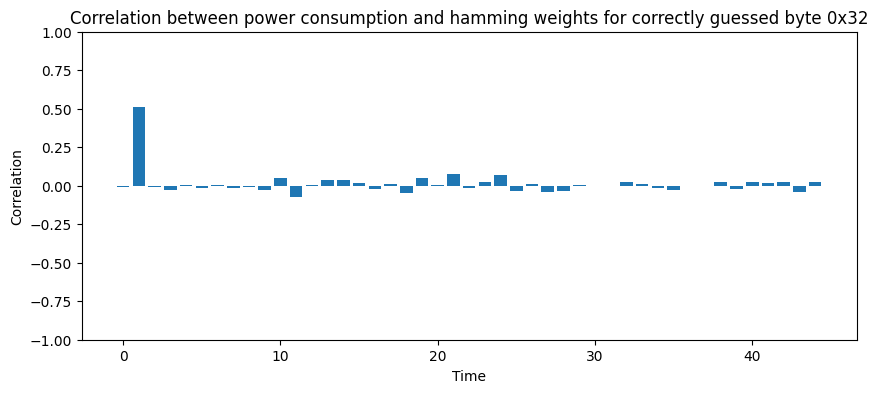

In [14]:
# Print correlation in comparison to time

guessed_key = np.zeros((4,), dtype=np.uint32)
guessed_byte = key[3] & 0xFF
guessed_key[3] |= guessed_byte

predicted_hws = np.array(
        [get_hw_for_guessed_key_byte(m[0], guessed_key, 0, 0xFF) for m in measurements], 
        dtype=np.uint32)

consumptions = np.array([m[2] for m in measurements], dtype=np.uint32)
corrs = np.array([np.corrcoef(predicted_hws, consumptions[:, t])[0, 1] for t in range(VALS_PER_MEASUREMENT)], dtype=np.float64)

plt.figure(figsize=(10,4))
x = np.arange(len(corrs))
plt.bar(x, corrs)
plt.xlabel("Time")
plt.ylabel("Correlation")
plt.title(f"Correlation between power consumption and hamming weights for correctly guessed byte 0x{guessed_byte:02X}")
plt.ylim(-1, 1)
plt.show()

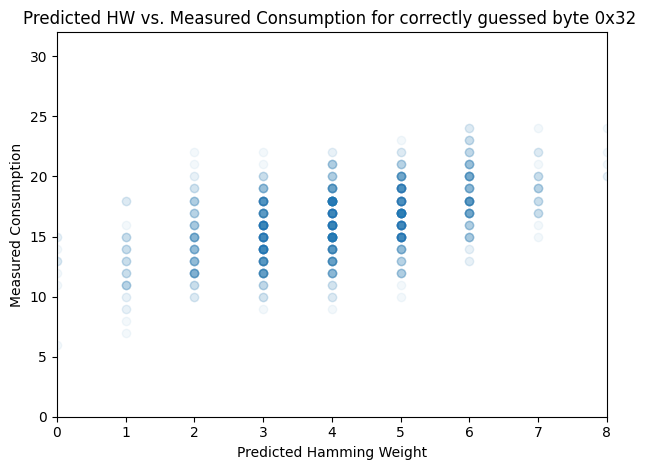

In [15]:
# Print correlation for a correct key byte

guessed_key = np.zeros((4,), dtype=np.uint32)
guessed_byte = key[3] & 0xFF
guessed_key[3] = key[3] & 0xFF

predicted_hws = np.array(
        [get_hw_for_guessed_key_byte(m[0], guessed_key, 0, 0xFF) for m in measurements], 
        dtype=np.uint32)

consumptions = np.array([m[2] for m in measurements], dtype=np.uint32)
corrs = np.array([np.corrcoef(predicted_hws, consumptions[:, t])[0, 1] for t in range(VALS_PER_MEASUREMENT)], dtype=np.float64)

# find the index where correlation is highest
max_corr_index = np.argmax(corrs)
consumptions_with_best_corr = consumptions[:, max_corr_index]

plt.scatter(predicted_hws, consumptions_with_best_corr, alpha=0.05)
plt.xlabel("Predicted Hamming Weight")
plt.ylabel("Measured Consumption")
plt.title(f"Predicted HW vs. Measured Consumption for correctly guessed byte 0x{guessed_byte:02X} ")
plt.tight_layout()
plt.xlim(0, 8)
plt.ylim(0, 32)
plt.show()


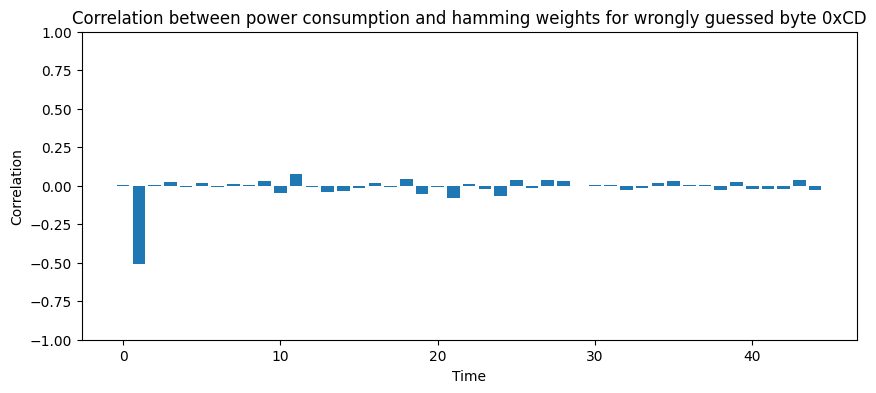

In [16]:
# Print correlation in comparison to time

guessed_key = np.zeros((4,), dtype=np.uint32)
guessed_byte = (~key[3] & 0xFF)
guessed_key[3] &= 0xFFFFFFFF
guessed_key[3] |= guessed_byte

predicted_hws = np.array(
        [get_hw_for_guessed_key_byte(m[0], guessed_key, 0, 0xFF) for m in measurements], 
        dtype=np.uint32)

consumptions = np.array([m[2] for m in measurements], dtype=np.uint32)
corrs = np.array([np.corrcoef(predicted_hws, consumptions[:, t])[0, 1] for t in range(VALS_PER_MEASUREMENT)], dtype=np.float64)

plt.figure(figsize=(10,4))
x = np.arange(len(corrs))
plt.bar(x, corrs)
plt.xlabel("Time")
plt.ylabel("Correlation")
plt.title(f"Correlation between power consumption and hamming weights for wrongly guessed byte 0x{guessed_byte:02X}")
plt.ylim(-1, 1)
plt.show()

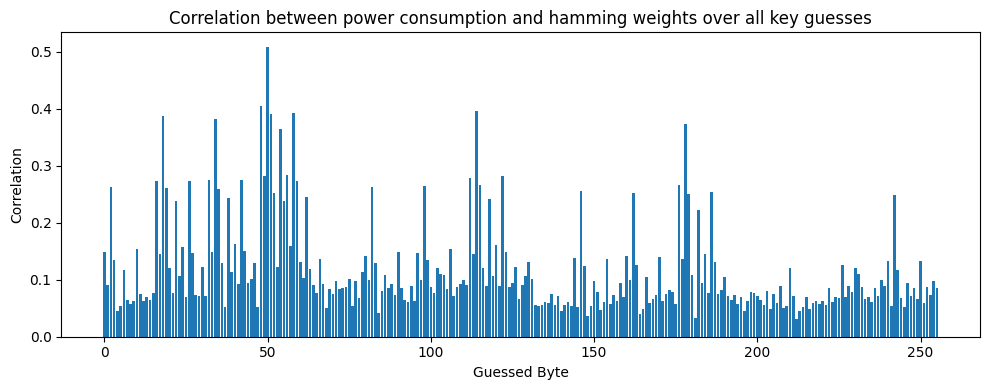

In [17]:
# Print max correlation for all guessed bytes

consumptions = np.array([m[2] for m in measurements], dtype=np.uint32)

max_corrs = np.zeros((256,), dtype=np.float64)


guessed_key = np.zeros((4,), dtype=np.uint32)
for guessed_byte in range(256):
    guessed_key[3] = guessed_byte

    predicted_hws = np.array(
            [get_hw_for_guessed_key_byte(m[0], guessed_key, 0, 0xFF) for m in measurements], 
            dtype=np.uint32)


    corrs = np.array([np.corrcoef(predicted_hws, consumptions[:, t])[0, 1] for t in range(VALS_PER_MEASUREMENT)], dtype=np.float64)
    max_corrs[guessed_byte] = np.max(corrs)

plt.figure(figsize=(10,4))
x = np.arange(len(max_corrs))
plt.bar(x, max_corrs)
plt.xlabel("Guessed Byte")
plt.ylabel("Correlation")
plt.title(f"Correlation between power consumption and hamming weights over all key guesses")
plt.tight_layout()
plt.show()